# Project 2: predicting sales prices with the Aimes Iowa Housing dataset

## Problem Statement

ABC Real Estate Agents needs a way to predict property sales prices so they may give potential customers a reliable estimate of the value of their property before they decide to engage them to find a buyer.

Currently, 50% of customers express dissatisfaction when the price potential buyers the company finds for their property to be much lower than the price estimates of the company's agents, sometimes resulting in wasted time for the company's agents when sellers change their minds about selling their properties. While such disappointments can be avoided by giving lower property price estimates, there is industry pressure to give a high valuation estimate as it gives sellers the impression that the agent is skilled.

Using data science to come up with a more reliable property price estimate, we can potentially increase customer satisfaction while quoting prices that are competitive in the industry.

## Data Import and Cleaning

Done in python file \project_2\code\01_data_cleaning.py

## Exploratory Data Analysis

#### 1. Read In Data

Read in the data.

In [ ]:
### Just for personal reference

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn.preprocessing as skpp
import sklearn.model_selection as skms
import sklearn.linear_model as sklm
import sklearn.metrics as skm


def ordinal_scale(df, mapping=None, start_num=0):
    '''
    A convenience mapping function that accepts a DataFrame and returns it with
    each column defined as keys in the mapping dictionary mapped to its values.
    '''
    if mapping:
        cols = mapping.keys()
        for col in cols:
            df[col] = df[col].map(
                {k: i+start_num for i, k in enumerate(mapping[col])})
            if df[col].isnull().sum() > 0:
                print(
                    f'WARNING: not all values in column "{col}" were mapped.')
    else:
        cols = df.columns
        ord = skpp.OrdinalEncoder()
        df[cols] = ord.fit_transform(df[cols])
    return df


def vif_feature_select(df, max_score=5.0, n_features=-1, inplace=False, drop_list=False, drops=None):
    '''
    Takes a DataFrame and returns it after recursively eliminating columns
    with the highest VIF scores until either the remainder have a VIF score
    of less than max_score, or there are n_features left.
    '''
    if not inplace:
        df = df.copy()
    if not drops:
        drops = []
    features = df.columns
    vifs = np.linalg.inv(df.corr().values).diagonal()
    max_vif_index = np.argmax(vifs)
    if n_features < 0 and vifs[max_vif_index] >= max_score:
        drops.append(features[max_vif_index])
        del df[features[max_vif_index]]
        return vif_feature_select(df, max_score, n_features, inplace, drop_list, drops)
    elif n_features >= 0 and len(features) > n_features:
        drops.append(features[max_vif_index])
        del df[features[max_vif_index]]
        return vif_feature_select(df, max_score, n_features, inplace, drop_list, drops)
    else:
        if drop_list:
            print('returning list of dropped features.')
            return drops
        else:
            return df


def subplot_dist(df, kind='dist', cols=None, titles=None, xlabels=None, ylabels=None, meanline=False, medianline=False, **kwargs):
    # Accepts all columns if they can be converted to numbers if cols argument
    # is not given.
    if not cols:
        cols = []
        if kind == 'count':
            cols = [x for x in df.select_dtypes(include='object').columns]
        else:
            for col in df.columns:
                try:
                    df[col] = pd.to_numeric(df[col])
                    cols.append(col)
                except ValueError:
                    pass

    # Sets number of figure rows based on number of DataFrame columns.
    if len(cols) > 4:
        ncols = 3
        nrows = int(np.ceil(len(cols)/3))
    else:
        ncols = 2
        nrows = int(np.ceil(len(cols)/2))
    # Sets figure size based on number of figure rows.
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 5*nrows))
    # Makes the list of lists flat.
    ax = ax.ravel()

    for i, col in enumerate(cols):
        is_list = isinstance(col, (list, tuple))
        if is_list and kind != 'box':
            print('distplot does not plot multiple series in one graph.')
            continue
        if kind == 'dist':
            sb.distplot(df[col], ax=ax[i], **kwargs)
            if meanline:
                ax[i].axvline(np.mean(df[col]), color='r',
                              linestyle='-', linewidth=1)
            if medianline:
                ax[i].axvline(np.median(df[col]), color='purple',
                              linestyle='--', linewidth=1)
        # Boxplotting option.
        elif kind == 'box':
            sb.boxplot(data=df[col], ax=ax[i], **kwargs)
            if not is_list and meanline:
                ax[i].axhline(np.mean(df[col]), color='r',
                              linestyle='-', linewidth=1)
        # Countplot option for nominal variables.
        elif kind == 'count':
            sb.countplot(x=col, data=df, ax=ax[i], **kwargs)

        if titles:
            ax[i].set_title(titles[i])
        if xlabels:
            ax[i].set_xlabel(xlabels[i])
        if ylabels:
            ax[i].set_ylabel(ylabels[i])


def adj_r2(X, y, y_hat):
    return 1 - (1-skm.r2_score(y, y_hat))*(len(y)-1)/(len(y)-X.shape[1]-1)


__all__ = ['np', 'pd', 'sb', 'plt', 'skpp', 'skms',
           'sklm', 'skm', 'ordinal_scale', 'vif_feature_select', 'subplot_dist', 'adj_r2']

In [1]:
from python_imports import * ### good organisation, but wildcard imports bad practice

%matplotlib inline

In [2]:
# Load data.
import_path = r'..\datasets\clean_train.csv'
# Dataset contains NA strings that should not be considered null values.
data = pd.read_csv(import_path, keep_default_na=False, na_values=['']) ### Not good practise to immediately impute with ''
                                                                       ### NAs could correspond to different values 
                                                                       ### depending on the features NA for garage size 
                                                                       ### could signal that no garage is present, 
                                                                       ### and should be imputed with zero. 
                                                                       ### while NA for other features could mean someone 
                                                                       ### forgot to type it in the dataset and should 
                                                                       ### be imputed with the mean/median/mode.
import_path = r'..\datasets\clean_test.csv'
# Dataset contains NA strings that should not be considered null values.
data2 = pd.read_csv(import_path, keep_default_na=False, na_values=[''])

In [3]:
# Separate the target variable from the dataset.
df_target = data['saleprice']

In [4]:
features = [x for x in data.columns if x != 'saleprice']
# Join train and test datasets in preparation for preprocessing.
df_features = data[features].append(data2) ### Very good

In [5]:
# Confirm join is successful. Since join='outer', nulls will be present if the DataFrames were not joined correctly.
np.sum(df_features.isnull().sum())

0

In [6]:
df_features.shape

(2901, 77)

In [7]:
df_features.columns

Index(['ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street',
       'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config',
       'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod/add', 'roof_style', 'roof_matl', 'exterior_1st',
       'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual',
       'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2',
       'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air',
       'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual',
       'totrms_abvgrd', 'functional', 'fireplaces', 'fireplace_qu',
       'garage_type', 'garage_finish', 'garage_cars', 'garage

In [8]:
# Convert ordinal values to numbers.
ordinal_vars = ['Lot Shape', 'Utilities', 'Land Slope', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence']
ordinal_vars = [x.lower().replace(' ', '_') for x in ordinal_vars]

In [9]:
ordinal_values = [
    ['IR3', 'IR2', 'IR1', 'Reg'],
    ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    ['Sev', 'Mod', 'Gtl'],
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['NA', 'No', 'Mn', 'Av', 'Gd'],
    ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['NA', 'Unf', 'RFn', 'Fin'],
    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['N', 'P', 'Y'],
    ['NA', 'Fa', 'TA', 'Gd', 'Ex'],
    ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
]

In [10]:
ordinals = zip(ordinal_vars, ordinal_values)

In [11]:
ordinal_map = {k: v for k, v in ordinals}
ordinal_map

{'lot_shape': ['IR3', 'IR2', 'IR1', 'Reg'],
 'utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
 'land_slope': ['Sev', 'Mod', 'Gtl'],
 'exter_qual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'exter_cond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'bsmt_qual': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'bsmt_cond': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'bsmt_exposure': ['NA', 'No', 'Mn', 'Av', 'Gd'],
 'bsmtfin_type_1': ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 'bsmtfin_type_2': ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 'heating_qc': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
 'kitchen_qual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
 'fireplace_qu': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'garage_finish': ['NA', 'Unf', 'RFn', 'Fin'],
 'garage_qual': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'garage_cond': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'paved_drive': ['N', 'P', 'Y'],
 'p

In [12]:
df_ord = ordinal_scale(df_features, ordinal_map)

In [13]:
nominal = ['MS SubClass', 'MS Zoning', 'Street', 'alley', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 'Garage Type', 'Misc Feature', 'Sale Type']
nominal = [x.lower().replace(' ', '_') for x in nominal]

In [14]:
non_norminal = [x for x in df_features if x not in nominal]

In [15]:
df_features[non_norminal].shape

(2901, 55)

In [16]:
# Eliminate features with a Variance Inflation Factor of more than 5.0, as these are highly correlated with each other.
dropped_features = vif_feature_select(df_features[non_norminal], drop_list=True)

returning list of dropped features.


In [17]:
dropped_features

['bsmtfin_sf_1', 'garage_cond', 'total_bsmt_sf', 'garage_cars', 'year_built']

In [18]:
df_features.drop(dropped_features, axis=1, inplace=True)

In [19]:
df_features.shape

(2901, 72)

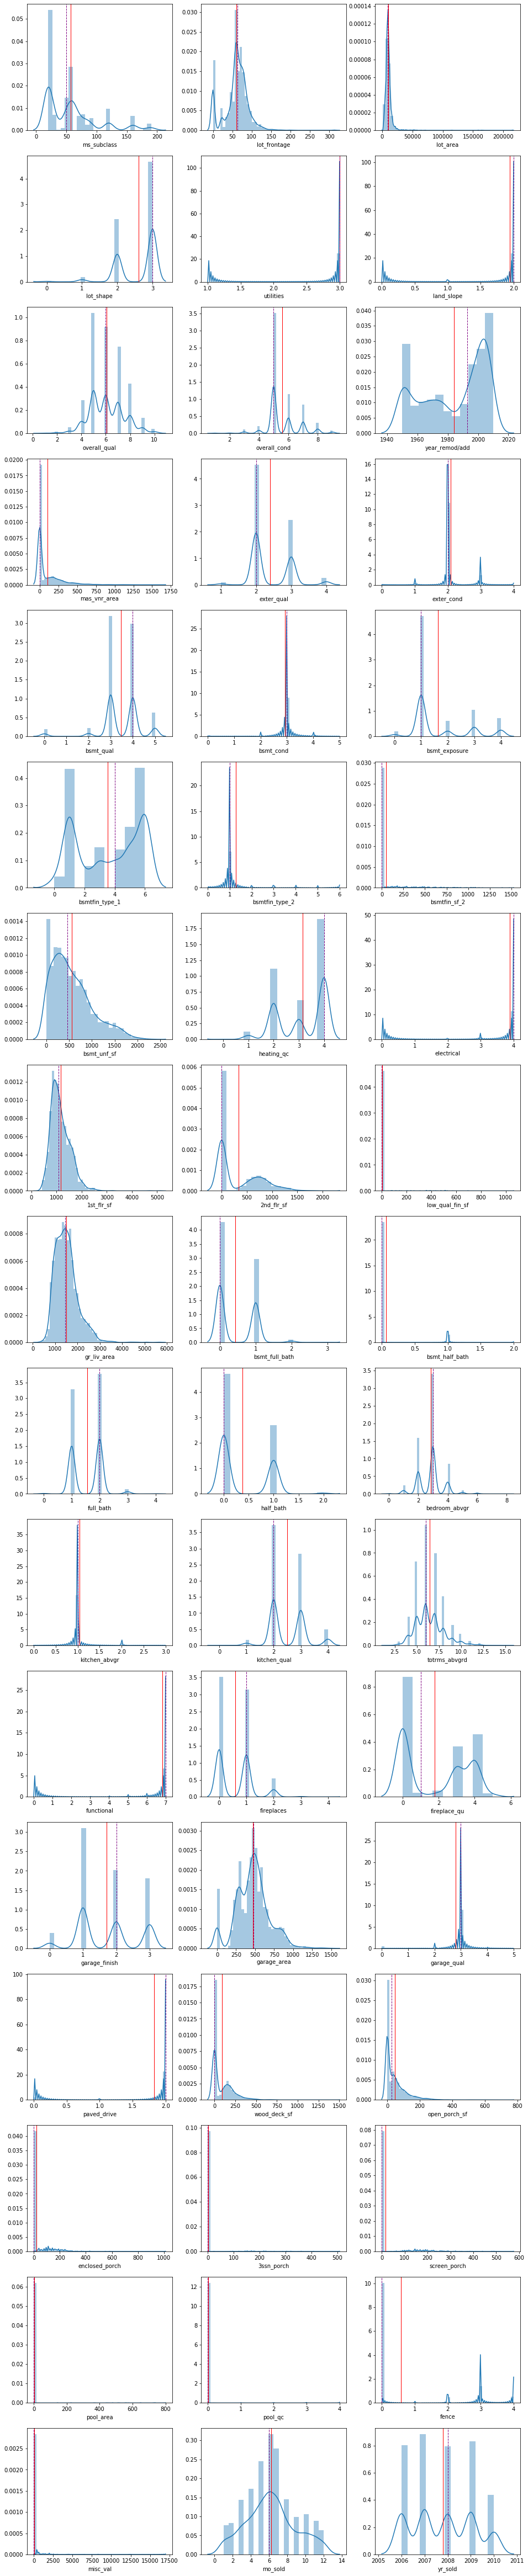

In [20]:
# Visualize continuous and ordinal variables.
subplot_dist(df_features, meanline=True, medianline=True) ### You should not be trying to plot KDEs for everything. 
                                                          ### select the features for which KDEs make sense and plot them 
                                                          ### On a separate note, histograms tend to hide anomalies so 
                                                          ### it might be a good idea to plot the unbinned numerical data
                                                          ### using a scatterplot so that the dataset can be cleaned.

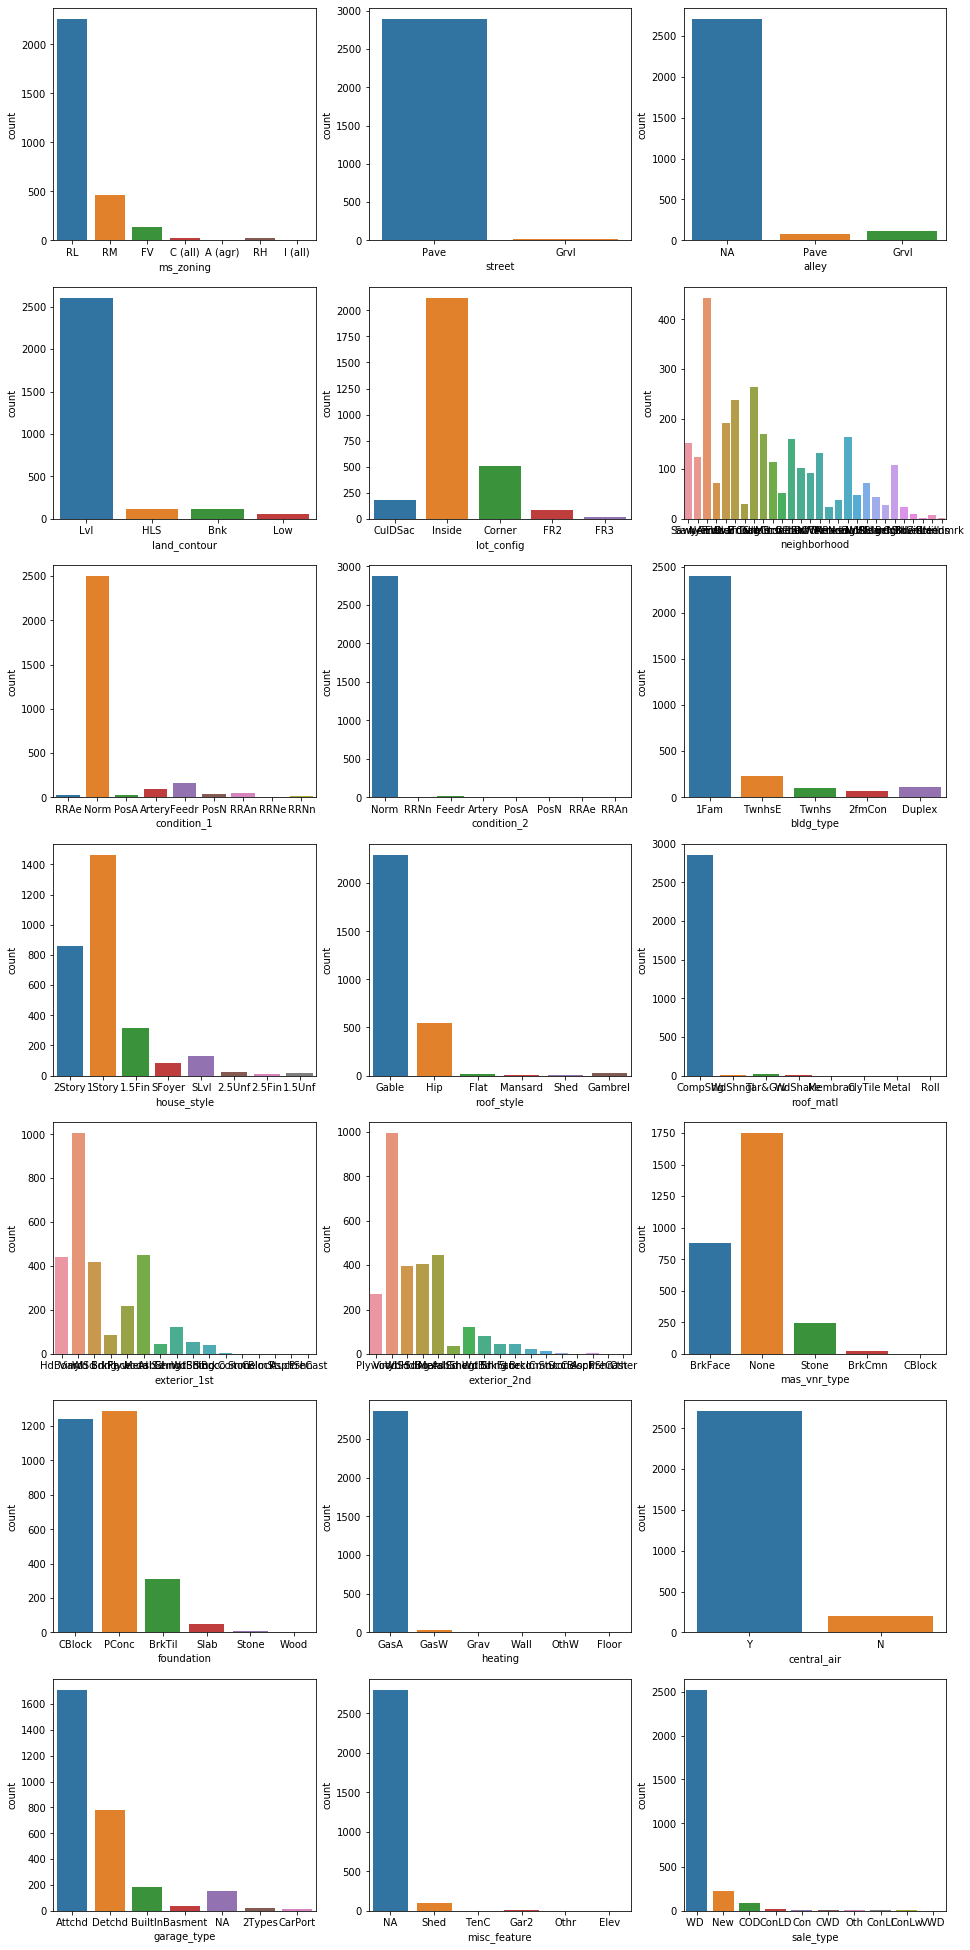

In [21]:
# Visualize categorical variables.
subplot_dist(df_features, kind='count')  ### Some x axis labels not readable (neighborhood). 
                                         ### Rotate the x-axis labels so that they can be read, or plot separately

In [22]:
df_features.describe()   ### Transpose here so you don't have the scroll left to right df_features.describe().T

ms_subclass  lot_frontage       lot_area    lot_shape    utilities  \
count  2901.000000   2901.000000    2901.000000  2901.000000  2901.000000   
mean     57.502585     60.807000   10128.736643     2.599104     2.998621   
std      42.737092     30.428167    7873.652972     0.570166     0.045465   
min      20.000000      0.000000    1300.000000     0.000000     1.000000   
25%      20.000000     50.000000    7424.000000     2.000000     3.000000   
50%      50.000000     63.000000    9428.000000     3.000000     3.000000   
75%      70.000000     78.000000   11515.000000     3.000000     3.000000   
max     190.000000    313.000000  215245.000000     3.000000     3.000000   

        land_slope  overall_qual  overall_cond  year_remod/add  mas_vnr_area  \
count  2901.000000   2901.000000   2901.000000     2901.000000   2901.000000   
mean      1.945881      6.085832      5.567391     1984.092727    101.912345   
std       0.249484      1.409772      1.114184       20.859531    179.205102   
min       0.000000      1.000000      1.000000     1950.000000      0.000000   
25%       2.000000      5.000000      5.000000     1965.000000      0.000000   
50%       2.000000      6.000000      5.000000     1993.000000      0.000000   
75%       2.000000      7.000000      6.000000     2004.000000    164.000000   
max       2.000000     10.000000      9.000000     2010.000000   1600.000000   

       ...  open_porch_sf  enclosed_porch   3ssn_porch  screen_porch  \
count  ...    2901.000000     2901.000000  2901.000000   2901.000000   
mean   ...      47.178559       23.030679     2.618407     16.162013   
std    ...      67.051004       64.158318    25.265382     56.344164   
min    ...       0.000000        0.000000     0.000000      0.000000   
25%    ...       0.000000        0.000000     0.000000      0.000000   
50%    ...      27.000000        0.000000     0.000000      0.000000   
75%    ...      70.000000        0.000000     0.000000      0.000000   
max    ...     742.000000     1012.000000   508.000000    576.000000   

         pool_area      pool_qc        fence      misc_val      mo_sold  \
count  2901.000000  2901.000000  2901.000000   2901.000000  2901.000000   
mean      2.265770     0.012410     0.583247     51.141331     6.209583   
std      35.774013     0.197879     1.219546    569.146217     2.712333   
min       0.000000     0.000000     0.000000      0.000000     1.000000   
25%       0.000000     0.000000     0.000000      0.000000     4.000000   
50%       0.000000     0.000000     0.000000      0.000000     6.000000   
75%       0.000000     0.000000     0.000000      0.000000     8.000000   
max     800.000000     4.000000     4.000000  17000.000000    12.000000   

           yr_sold  
count  2901.000000  
mean   2007.792485  
std       1.318185  
min    2006.000000  
25%    2007.000000  
50%    2008.000000  
75%    2009.000000  
max    2010.000000  

[8 rows x 51 columns]

In [23]:
# Convert nominal features into dummies.
df_dum = pd.get_dummies(data=df_features, columns=nominal, drop_first=True)

In [24]:
df_dum.shape

(2901, 212)

## Model Preparation

#### 1. Scaling

In [25]:
ss = skpp.StandardScaler()
df_ss = pd.DataFrame(ss.fit_transform(df_dum), columns=df_dum.columns)

#### 2. Tain test split

In [26]:
y_train = df_target

In [27]:
X_train = df_ss[:data.shape[0]]
X_test = df_ss[data.shape[0]:]  ### Good

#### 3. Instantiate models

In [28]:
lr = sklm.LinearRegression()
lasso = sklm.LassoCV(n_alphas=200, cv=5)
ridge = sklm.RidgeCV(alphas=np.linspace(.1, 10, 100))

## Cross Validation

In [29]:
lr_scores = skms.cross_val_score(lr, X_train, y_train, cv=5)
lr_scores.mean()

-1.4488525258824868e+22

In [30]:
lasso_scores = skms.cross_val_score(lasso, X_train, y_train, cv=5)
lasso_scores.mean()

0.8597750193270584

In [31]:
ridge_scores = skms.cross_val_score(ridge, X_train, y_train, cv=5)
ridge_scores.mean()

0.8501436449259041

## Model Fitting and Evaluation

In [32]:
lasso.fit(X_train, y_train)    ### A quick explanation on why lasso was chosen would have been appropriate

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=200, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [33]:
lasso.score(X_train, y_train)

0.8956396764102929

In [34]:
pred = lasso.predict(X_test)

In [35]:
pred

array([130335.79116641, 163296.72358577, 228511.49192302, 112692.17347009,
       187758.97223285,  81332.1218118 ,  98394.53966558, 160039.70162632,
       177284.05371118, 160474.15903442, 148111.54376758, 121274.77549013,
       147957.42129526, 267256.04799148, 151470.91065642, 124437.72136158,
       166448.94799022, 118564.0022023 , 193117.43924604, 194408.0503726 ,
       156351.70314772, 122495.149902  , 179701.46205632, 158959.65066605,
       179535.94357531, 121416.50243365, 136376.85106972, 137512.33351202,
       168543.68305062,  22684.4415349 , 101562.36701158, 101701.353241  ,
       199636.39337833, 150482.79981891, 227481.58095656, 177308.51412201,
       111556.59704785,  69841.47048835, 144465.03138166, 200450.54454467,
       171395.02256392, 204660.65566028, 154968.0960735 , 164199.78336029,
       211939.54485971,  92742.86514356, 227528.8506101 , 123395.80546465,
       133304.01782559, 113225.65739343,  99662.5675194 , 218992.00794217,
       239716.86183442, 1

In [36]:
# Load data.
import_path = r'..\datasets\test.csv'
# Dataset contains NA strings that should not be considered null values.
data3 = pd.read_csv(import_path, keep_default_na=False, na_values=[''])

In [37]:
data3.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0  2658  902301120          190        RM          69.0      9142   Pave   
1  2718  905108090           90        RL           NaN      9662   Pave   
2  2414  528218130           60        RL          58.0     17104   Pave   
3  1989  902207150           30        RM          60.0      8520   Pave   
4   625  535105100           20        RL           NaN      9500   Pave   

  Alley Lot Shape Land Contour  ... 3Ssn Porch Screen Porch Pool Area Pool QC  \
0  Grvl       Reg          Lvl  ...          0            0         0      NA   
1    NA       IR1          Lvl  ...          0            0         0      NA   
2    NA       IR1          Lvl  ...          0            0         0      NA   
3    NA       Reg          Lvl  ...          0            0         0      NA   
4    NA       IR1          Lvl  ...          0          185         0      NA   

  Fence Misc Feature Misc Val Mo Sold  Yr Sold  Sale Type  
0    NA           NA        0       4     2006        WD   
1    NA           NA        0       8     2006        WD   
2    NA           NA        0       9     2006        New  
3    NA           NA        0       7     2007        WD   
4    NA           NA        0       7     2009        WD   

[5 rows x 80 columns]

In [38]:
df_submit = pd.concat([data3['Id'], pd.DataFrame(pred)], axis=1)

In [39]:
df_submit.columns = ['Id', 'SalePrice']

In [40]:
export_path = r'..\datasets\submission.csv'
df_submit.to_csv(export_path, index=False)

In [41]:
lasso.coef_

array([ 0.00000000e+00,  2.86958505e+03,  0.00000000e+00,  6.03601134e+01,
       -0.00000000e+00,  1.40140262e+04,  2.41202419e+03,  1.41141698e+03,
        4.16736291e+03,  6.08318969e+03,  0.00000000e+00,  3.11376879e+03,
       -3.70705638e+01,  5.15055313e+03,  3.16969130e+03, -0.00000000e+00,
        0.00000000e+00, -1.82602754e+03,  1.32257001e+03, -0.00000000e+00,
        5.77096636e+03,  0.00000000e+00, -0.00000000e+00,  1.98305763e+04,
        3.19900131e+03, -0.00000000e+00,  1.81209433e+03,  8.89987933e+02,
       -0.00000000e+00, -1.30236772e+03,  6.03298770e+03,  3.46635057e+02,
        2.01016009e+03,  1.88553506e+03,  2.20284019e+03,  6.18944506e+02,
        5.17935474e+03, -0.00000000e+00,  0.00000000e+00,  1.67777672e+03,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  3.62064420e+03,
       -0.00000000e+00, -2.40906958e+03,  0.00000000e+00, -6.84055018e+03,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  

In [42]:
coeff_names = {k: v for k, v in zip(X_train, lasso.coef_)}

In [43]:
coeff_names  ### Good

{'lot_frontage': 0.0,
 'lot_area': 2869.585053818533,
 'lot_shape': 0.0,
 'utilities': 60.36011341454302,
 'land_slope': -0.0,
 'overall_qual': 14014.026208796227,
 'overall_cond': 2412.0241938976587,
 'year_remod/add': 1411.4169792913412,
 'mas_vnr_area': 4167.362909443754,
 'exter_qual': 6083.18969119687,
 'exter_cond': 0.0,
 'bsmt_qual': 3113.7687930242696,
 'bsmt_cond': -37.07056375689175,
 'bsmt_exposure': 5150.553126621268,
 'bsmtfin_type_1': 3169.6912982238646,
 'bsmtfin_type_2': -0.0,
 'bsmtfin_sf_2': 0.0,
 'bsmt_unf_sf': -1826.0275374364294,
 'heating_qc': 1322.5700062480964,
 'electrical': -0.0,
 '1st_flr_sf': 5770.9663567551615,
 '2nd_flr_sf': 0.0,
 'low_qual_fin_sf': -0.0,
 'gr_liv_area': 19830.576339300584,
 'bsmt_full_bath': 3199.001306043703,
 'bsmt_half_bath': -0.0,
 'full_bath': 1812.0943298680372,
 'half_bath': 889.9879332216759,
 'bedroom_abvgr': -0.0,
 'kitchen_abvgr': -1302.367719075781,
 'kitchen_qual': 6032.987702299065,
 'totrms_abvgrd': 346.635057006163,
 'func

In [44]:
coeff_names = {k: v for k, v in coeff_names.items() if v > 0} ### This is wrong. This will filter out features that have 
                                                              ### positive relationships with price. ie if they increase,
                                                              ### the sales price will also increase. There are also 
                                                              ### features with negative relations, which will decrease 
                                                              ### the sales price if they increase such as
                                                              ### neighborhood_Edwards. They should not be excluded from
                                                              ### the model. 
                                                              ###
                                                              ### What you probably want to do is to get rid of 
                                                              ### non significantly predictive features, ie 
                                                              ### filter for abs(v) < threshold.

In [45]:
df_coeff = pd.DataFrame(coeff_names, index=['coefficient'])

In [46]:
df_coeff

lot_area  utilities  overall_qual  overall_cond  \
coefficient  2869.585054  60.360113  14014.026209   2412.024194   

             year_remod/add  mas_vnr_area   exter_qual    bsmt_qual  \
coefficient     1411.416979   4167.362909  6083.189691  3113.768793   

             bsmt_exposure  bsmtfin_type_1  ...  exterior_2nd_VinylSd  \
coefficient    5150.553127     3169.691298  ...             311.85728   

             mas_vnr_type_Stone  foundation_PConc  foundation_Slab  \
coefficient          208.324788       1886.385246        99.896146   

             garage_type_BuiltIn  misc_feature_Gar2  misc_feature_Othr  \
coefficient           173.529135        2951.419471        2281.522946   

             misc_feature_Shed  sale_type_Con  sale_type_New  
coefficient         589.806076     998.671497    3503.865992  

[1 rows x 57 columns]

In [47]:
df_coeff = df_coeff.T

In [48]:
df_coeff = df_coeff.sort_values(by=['coefficient'], ascending=False)

In [50]:
df_coeff  ### Maybe a comment here on what is expected / what is not expected.

coefficient
gr_liv_area           19830.576339
overall_qual          14014.026209
neighborhood_NridgHt   9097.734715
neighborhood_StoneBr   6096.997128
exter_qual             6083.189691
kitchen_qual           6032.987702
1st_flr_sf             5770.966357
garage_area            5179.354744
bsmt_exposure          5150.553127
neighborhood_NoRidge   4234.499662
mas_vnr_area           4167.362909
screen_porch           3620.644198
sale_type_New          3503.865992
bsmt_full_bath         3199.001306
bsmtfin_type_1         3169.691298
bsmt_qual              3113.768793
misc_feature_Gar2      2951.419471
lot_area               2869.585054
land_contour_HLS       2666.254235
neighborhood_GrnHill   2505.478061
overall_cond           2412.024194
misc_feature_Othr      2281.522946
fireplace_qu           2202.840194
exterior_1st_BrkFace   2102.385337
roof_style_Hip         2093.302064
house_style_1Story     2030.081077
condition_1_Norm       2022.034241
functional             2010.160093
roof_matl_WdShngl      1930.846583
neighborhood_Somerst   1910.771942
foundation_PConc       1886.385246
fireplaces             1885.535059
full_bath              1812.094330
neighborhood_Crawfor   1690.475746
wood_deck_sf           1677.776724
lot_config_CulDSac     1602.376173
exterior_1st_CemntBd   1413.557284
year_remod/add         1411.416979
condition_1_PosN       1392.751897
heating_qc             1322.570006
roof_matl_CompShg      1040.001230
sale_type_Con           998.671497
half_bath               889.987933
condition_2_PosA        757.618413
garage_finish           618.944506
misc_feature_Shed       589.806076
totrms_abvgrd           346.635057
alley_NA                329.205175
condition_1_PosA        316.787208
exterior_2nd_VinylSd    311.857280
land_contour_Low        273.427439
roof_matl_Membran       241.573919
mas_vnr_type_Stone      208.324788
garage_type_BuiltIn     173.529135
neighborhood_NPkVill    118.797923
foundation_Slab          99.896146
utilities                60.360113

In [49]:
export_path = r'..\datasets\model_coefficients.csv'
df_coeff.to_csv(export_path, index=True)

In [ ]:
### Would be good to see a y_pred vs y_test plot here, and maybe another plot to check for residuals.
### Explanations for the data manipulations should be a lot more verbose. 